In this notebook we show how to simulate WIMP and CEvNS signal with wfsim

In [2]:
import numpy as np
import pandas as pd
import strax
import straxen
import wfsim
import cutax

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from multihist import Histdd, Hist1d
from scipy import stats
from scipy.interpolate import UnivariateSpline, interp1d

import wimprates
import numericalunits as nu
import nestpy



*** Detector definition message ***
You are currently using the default XENON10 template detector.

/opt/XENONnT/anaconda/envs/XENONnT_2023.07.1/lib/python3.9/site-packages/wimprates/__init__.py:6: UserWarning: Default WIMP parameters are changed in accordance with https://arxiv.org/abs/2105.00599 (github.com/JelleAalbers/wimprates/pull/14)
  warnings.warn(


In [3]:
straxen.print_versions(modules=('strax', 'straxen', 'cutax', 'wfsim', 'nestpy', 'ntauxfiles', 'wimprates'))

,module,version,path,git
0,python,3.9.17,/opt/XENONnT/anaconda/envs/XENONnT_2023.07.1/b...,None
1,strax,1.5.2,/opt/XENONnT/anaconda/envs/XENONnT_2023.07.1/l...,None
2,straxen,2.1.1,/opt/XENONnT/anaconda/envs/XENONnT_2023.07.1/l...,None
3,cutax,1.15.1,/home/shenyangshi/cutax/cutax,branch:bdt_ms | 277f174
4,wfsim,1.0.2,/opt/XENONnT/anaconda/envs/XENONnT_2023.07.1/l...,None
5,nestpy,2.0.0,/opt/XENONnT/anaconda/envs/XENONnT_2023.07.1/l...,None
6,ntauxfiles,0.3.0,/project2/lgrandi/shenyangshi/home/private_nt_...,branch:AmBe_ms_fit | 3555246
7,wimprates,0.5.0,/opt/XENONnT/anaconda/envs/XENONnT_2023.07.1/l...,None


First see the WIMP differential rate as a function of recoil energy

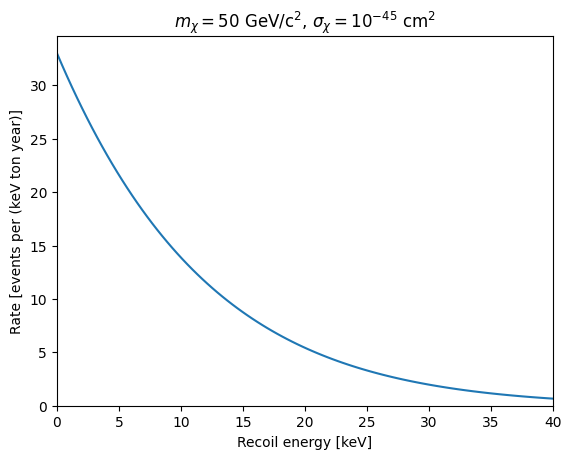

In [4]:
energies = np.linspace(0.01, 40, 100)
dr = wimprates.rate_wimp_std(energies, mw=50, sigma_nucleon=1e-45, material='Xe')

plt.plot(energies, dr)

plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title("$m_\chi = 50$ GeV/c${}^2$, $\sigma_\chi = 10^{-45}$ cm${}^2$")
plt.xlim(0, energies.max())
plt.ylim(0, None);

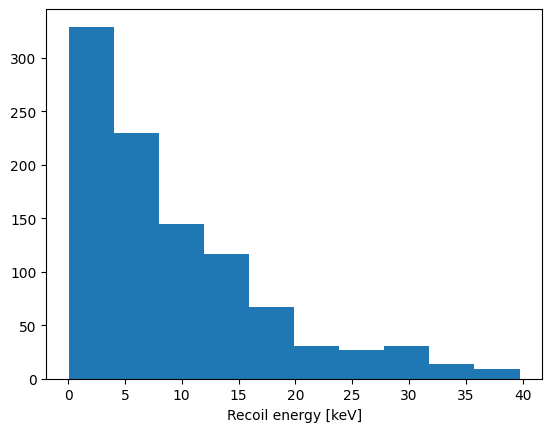

In [5]:
# How to bootstrap the energies?
dm_energies = np.linspace(0.01, 40, 100)
dr = wimprates.rate_wimp_std(energies, mw=50, sigma_nucleon=1e-45, material='Xe')
cumsum = np.cumsum(dr)       
cumsum = (cumsum - cumsum[0]) / (cumsum[-1] - cumsum[0])
plt.hist(interp1d(cumsum, dm_energies)(np.random.uniform(size=1000)))
plt.xlabel('Recoil energy [keV]')
plt.show()

In [6]:
def wimp_instruction(energies=np.linspace(0.01,40,100),
                     mw=50,
                     sigma_nucleon=1e-45,
                     n_events=100,
                     event_rate=10):

    tpc_radius = straxen.tpc_r
    tpc_length = straxen.tpc_z
    n = int(n_events)
    total_time = int(n_events / event_rate)

    instructions = np.zeros(2 * n, dtype=wfsim.instruction_dtype)
    instructions['event_number'] = np.repeat(np.arange(n), 2)

    r = np.sqrt(np.random.uniform(0, tpc_radius ** 2, n))
    theta = np.random.uniform(-np.pi, np.pi, n)
    instructions['x'] = np.repeat(r * np.cos(theta), 2)
    instructions['y'] = np.repeat(r * np.sin(theta), 2)
    instructions['z'] = np.repeat(np.random.uniform(-tpc_length, 0, n), 2)
    instructions['time'] = np.repeat(np.sort(np.random.uniform(low=0, high=total_time, size=n)),
                                     2) * straxen.units.s

    density = 2.81
    drift_field = 21.3
    recoil = 0  # NR
    instructions['type'] = np.tile([1, 2], n)
    instructions['recoil'] = np.full(2 * n, recoil)

    dm_energies = energies
    dr = wimprates.rate_wimp_std(energies, mw=mw, sigma_nucleon=sigma_nucleon, material='Xe')
                         
    cumsum = np.cumsum(dr)
    cumsum = (cumsum - cumsum[0]) / (cumsum[-1] - cumsum[0])
    energy = interp1d(cumsum, dm_energies)(np.random.uniform(size=n))

    nph = np.empty(n, int)
    ne = np.empty(n, int)

    nc = nestpy.NESTcalc(nestpy.VDetector())
    interaction = nestpy.INTERACTION_TYPE(0)
                         
    for i in range(n):
        y = nc.GetYields(interaction,
                         energy[i],
                         density,
                         drift_field, # Drift field, V/cm                                                                         
                         131.293,
                         54,
                         # (1,1)
                        )
        nph[i], ne[i] = y.PhotonYield, y.ElectronYield
        
        
    instructions['amp'] = np.vstack([nph, ne]).T.flatten()
    instructions['n_excitons'] = np.vstack([nph, np.zeros_like(ne)]).T.flatten()
    instructions['local_field'] = drift_field
    instructions['e_dep'] = np.repeat(energy, 2)
    return instructions


In [7]:
st = cutax.xenonnt_sim_base()

/home/shenyangshi/cutax/cutax/contexts.py:107: UserWarning: WARNING! You are using SR0_V0 simulation context! Consider updating to a newer/pinned version (SR0_V4)!
  warnings.warn(f'WARNING! You are using {faxconf_version.upper()} simulation context!'
/opt/XENONnT/anaconda/envs/XENONnT_2023.07.1/lib/python3.9/site-packages/straxen/url_config.py:711: UserWarning: From straxen version 2.1.0 onward, URLConfig parameterswill be sorted alphabetically before being passed to the plugins, this will change the lineage hash for non-sorted URLs. To load data processed with non-sorted URLs, you will need to use an older version.
  warnings.warn("From straxen version 2.1.0 onward, URLConfig parameters"
/home/shenyangshi/cutax/cutax/contexts.py:132: UserWarning: WARNING! [ FAX_CONFIG_NT_SR0_V0.JSON ] does not contain "field_distortion_correction_map" key!
  warnings.warn(f'WARNING! [ {fax_conf.upper()} ] does not contain "{fax_config_fdc_key}" key!')


In [9]:
run_id = '026000'
instruction = wimp_instruction(energies=np.linspace(0.01,40,100),
                                 mw=50,
                                 sigma_nucleon=1e-45,
                                 n_events=1000,
                                 event_rate=10)

instruction = instruction[instruction['amp'] > 0]
pd.DataFrame(instruction).to_csv(f'./026000.csv', index=False)

config_instruction = dict(event_rate=10,
                          chunk_size=10000,
                          nchunk=1,
                          peak_min_pmts=2,
                          fax_file=f'./026000.csv')

st.set_config(config_instruction)

In [10]:
st.make(run_id, 'raw_records', progress_bar=True)
st.make(run_id, 'event_info', progress_bar=True)

Removing old incomplete data in ./strax_data/026000-raw_records_aqmon-gkhxdhlrrd
Removing old incomplete data in ./strax_data/026000-truth-gkhxdhlrrd
Removing old incomplete data in ./strax_data/026000-raw_records-gkhxdhlrrd
Removing old incomplete data in ./strax_data/026000-raw_records_he-gkhxdhlrrd


/opt/XENONnT/anaconda/envs/XENONnT_2023.07.1/lib/python3.9/site-packages/wfsim/load_resource.py:262: RuntimeWarning: invalid value encountered in true_divide
  orig_aft_=np.mean((s2map_topeff_/s2map_toteff_)[s2map_toteff_>0.0])
*** Detector definition message ***
You are currently using the default XENON10 template detector.



Simulating Raw Records:   0%|          | 0/1893 [00:00<?, ?it/s]

Source finished!


Loading event_info: |          | 0.00 % [00:00<?]

/opt/XENONnT/anaconda/envs/XENONnT_2023.07.1/lib/python3.9/site-packages/strax/processing/general.py:384: UserWarning: endtime of things is not sorted! touching_windows will return the indices of the first and last things which are touching the container.
  warnings.warn(
/opt/XENONnT/anaconda/envs/XENONnT_2023.07.1/lib/python3.9/site-packages/strax/processing/general.py:384: UserWarning: endtime of things is not sorted! touching_windows will return the indices of the first and last things which are touching the container.
  warnings.warn(
/opt/XENONnT/anaconda/envs/XENONnT_2023.07.1/lib/python3.9/site-packages/strax/chunk.py:364: NumbaExperimentalFeatureWarning: Record(Start time of the peak (ns since unix epoch)[type=int64;offset=0;title=Start time of the peak (ns since unix epoch)],time[type=int64;offset=0;title=Start time of the peak (ns since unix epoch)],End time of the peak (ns since unix epoch)[type=int64;offset=8;title=End time of the peak (ns since unix epoch)],endtime[type=i

Found chunk without events?!


In [11]:
event_info = st.get_array('026000', 'event_info')

Loading event_info: |          | 0.00 % [00:00<?]

Text(0, 0.5, 'cs2')

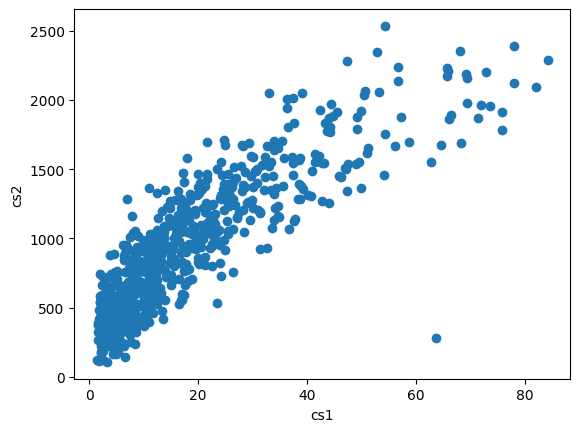

In [12]:
plt.scatter(event_info['cs1'], event_info['cs2'])
plt.xlabel('cs1')
plt.ylabel('cs2')
plt.show()

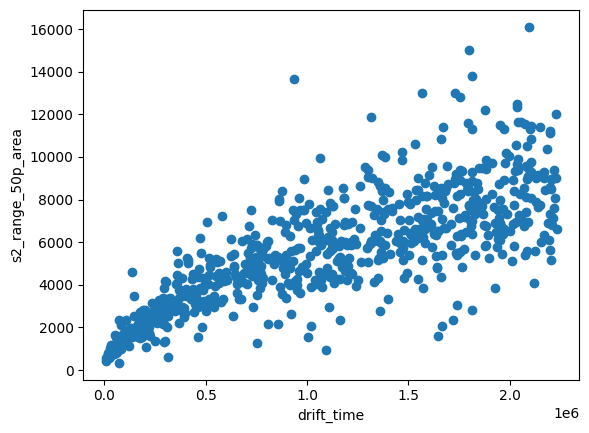

In [13]:
plt.scatter(event_info['drift_time'], event_info['s2_range_50p_area'])
plt.xlabel('drift_time')
plt.ylabel('s2_range_50p_area')
plt.show()